GRAPH VISUALIZATION
Loading graph from ./test_graph_output/simclr_files/03a3d1bac814f25da8e1f7c511cc10af...
✓ Loaded 155 nodes
✓ Features shape: torch.Size([155, 512])
✓ Adjacency shape: torch.Size([155, 155])

Generating visualizations...
----------------------------------------------------------------------
✓ Saved: graph_spatial_03a3d1bac814f25da8e1f7c511cc10af.png


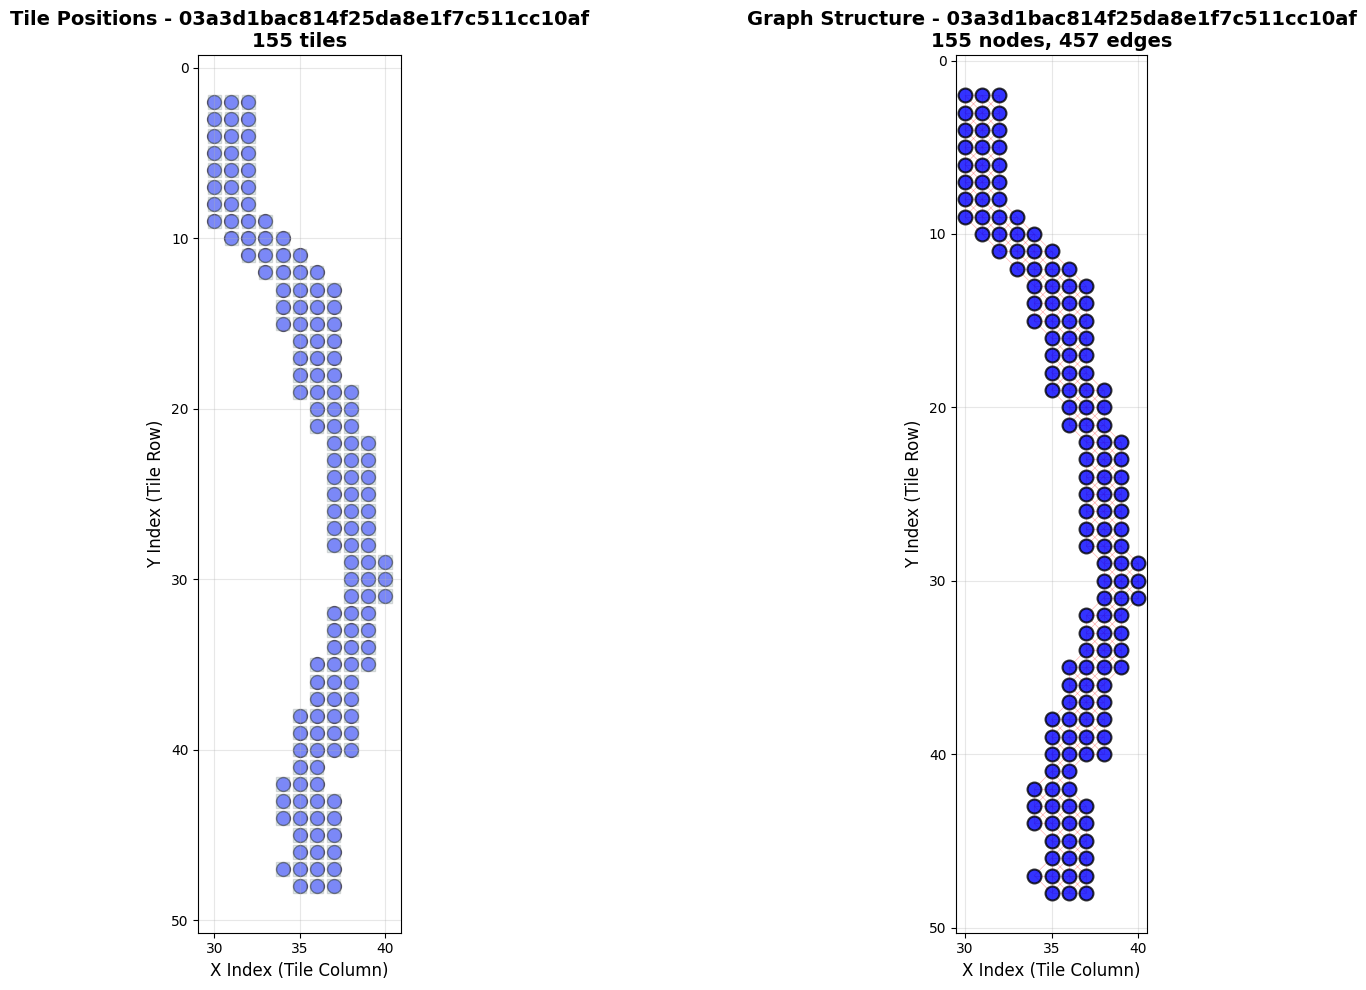

✓ Saved: graph_adjacency_03a3d1bac814f25da8e1f7c511cc10af.png


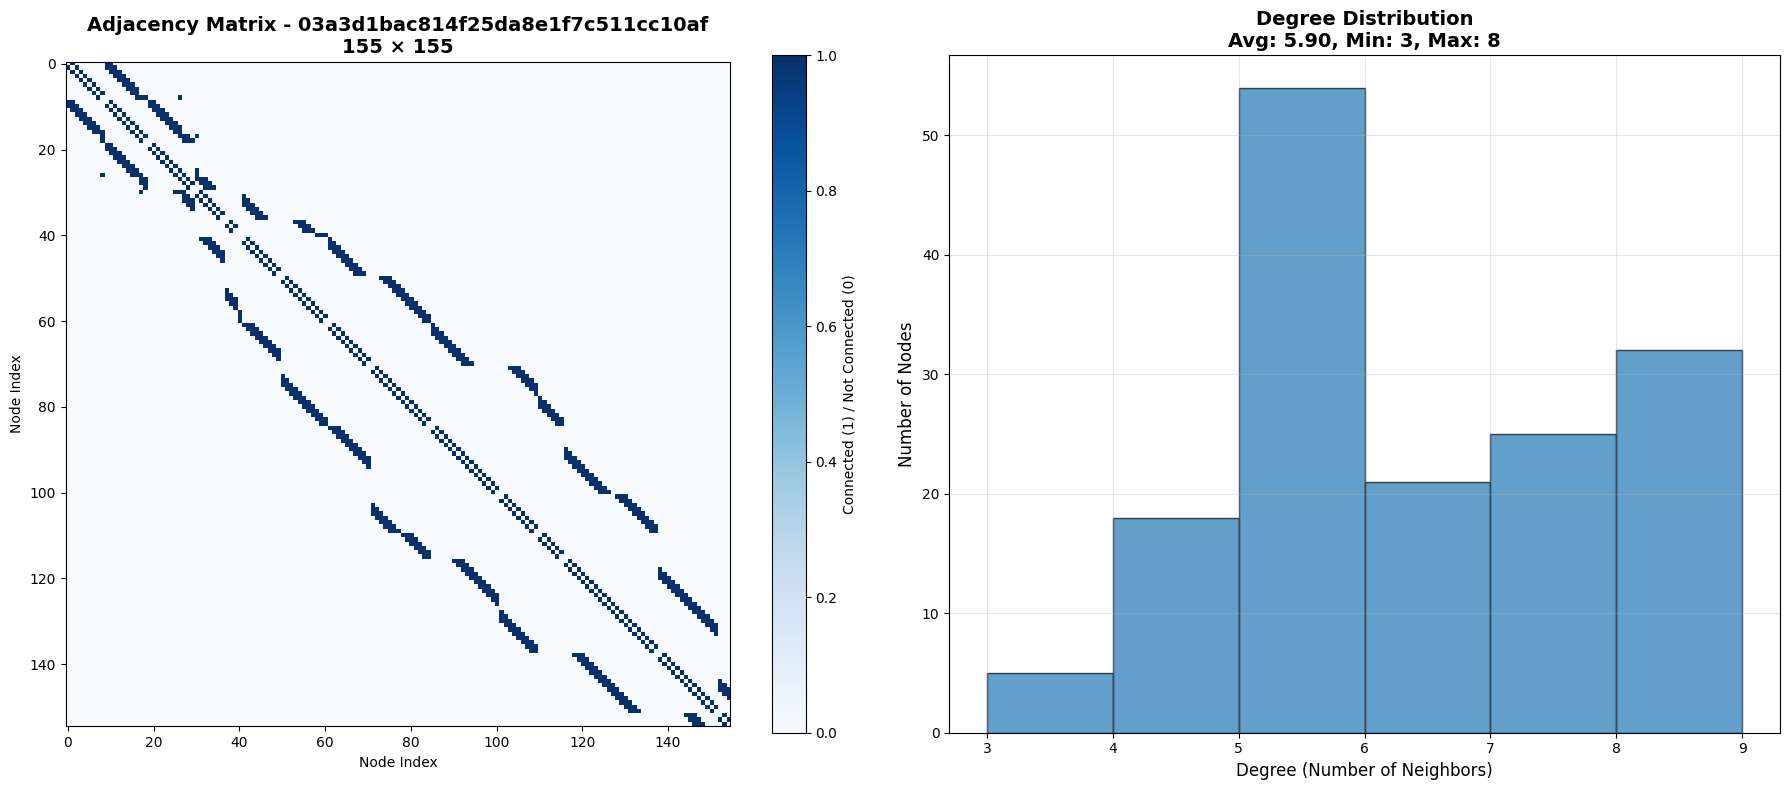

✓ Saved: graph_features_03a3d1bac814f25da8e1f7c511cc10af.png


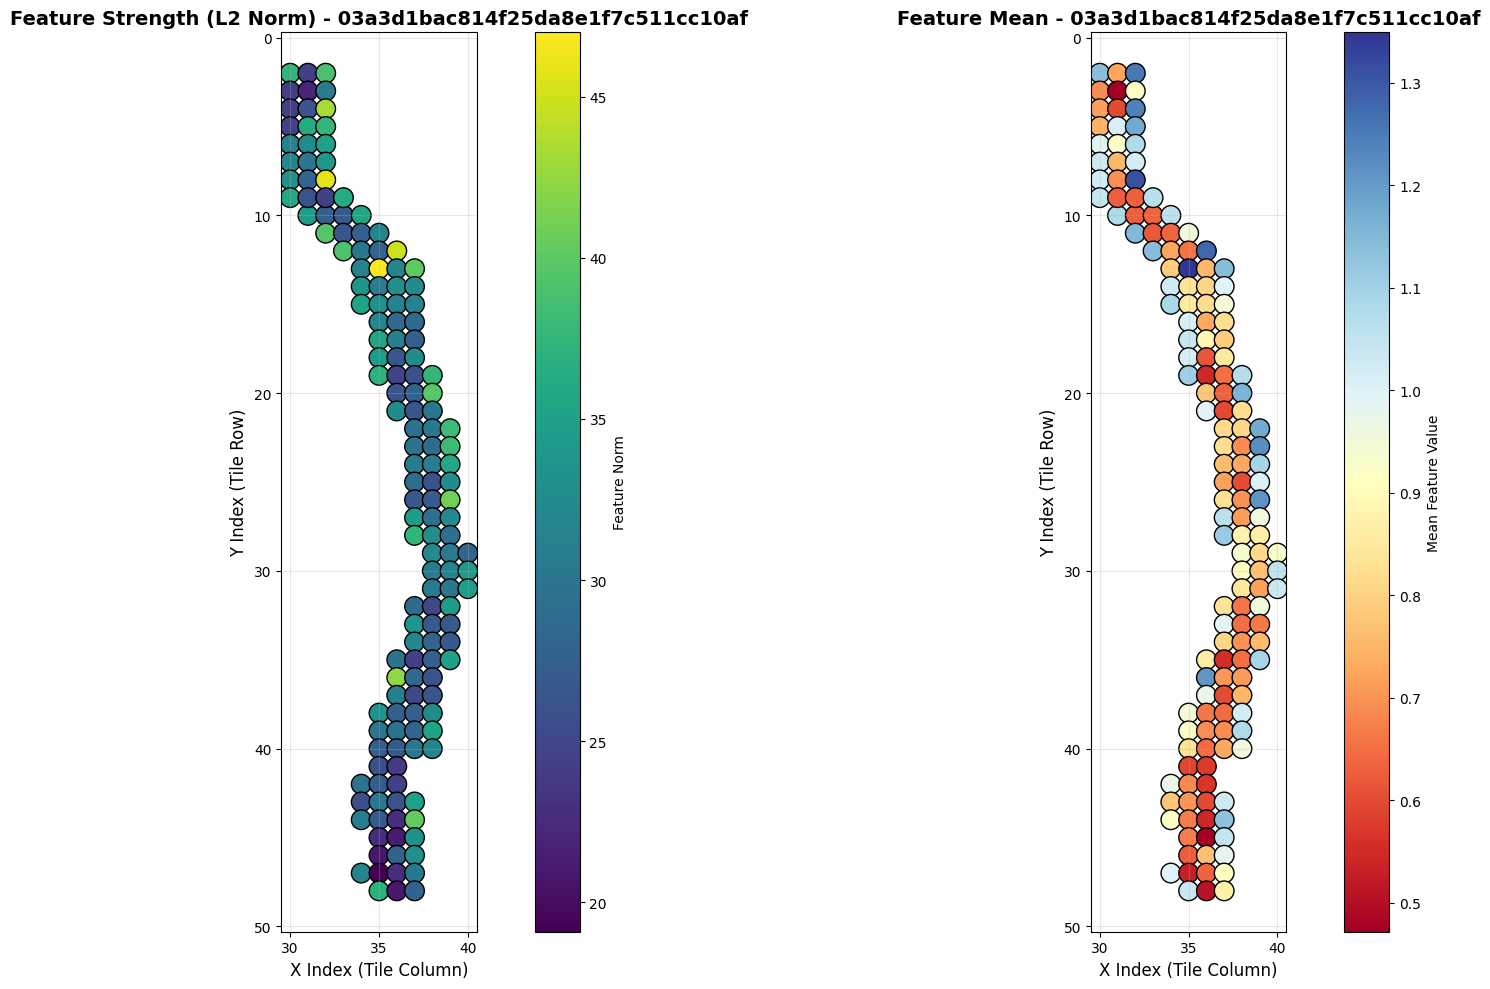

✓ Saved: graph_overview_03a3d1bac814f25da8e1f7c511cc10af.png


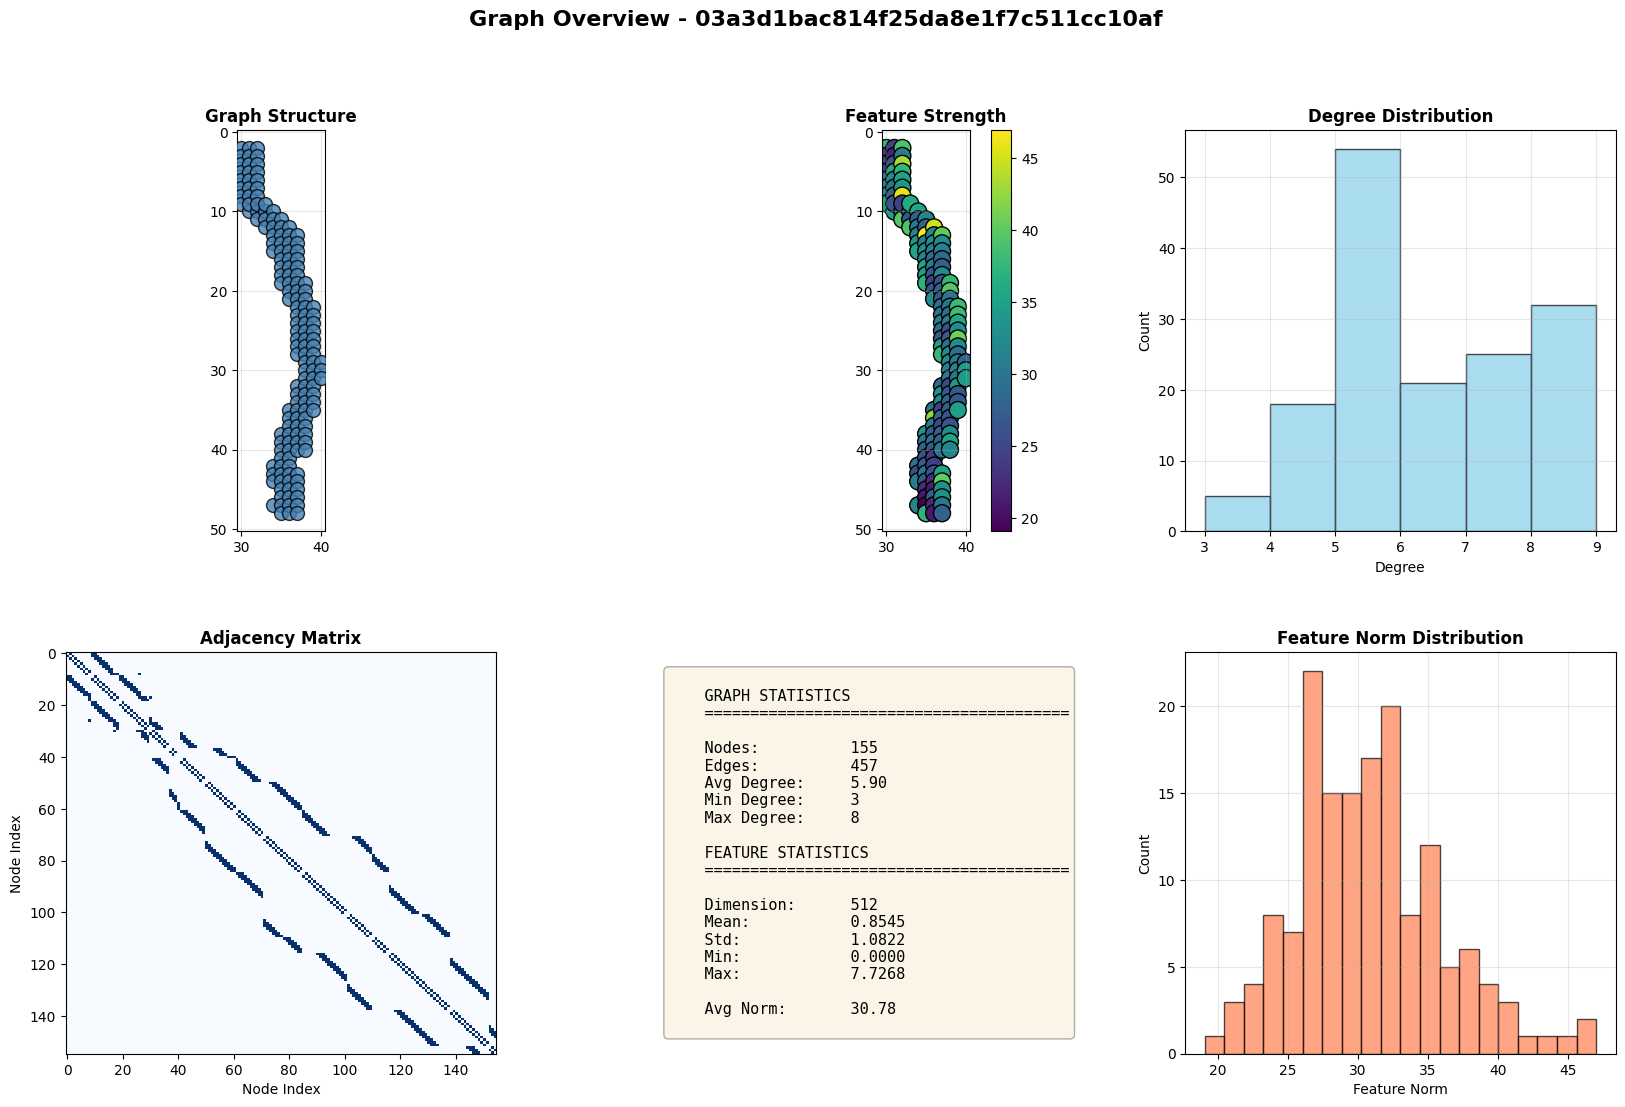


VISUALIZATION COMPLETE
Generated files:
  • graph_spatial_03a3d1bac814f25da8e1f7c511cc10af.png
  • graph_adjacency_03a3d1bac814f25da8e1f7c511cc10af.png
  • graph_features_03a3d1bac814f25da8e1f7c511cc10af.png
  • graph_overview_03a3d1bac814f25da8e1f7c511cc10af.png


In [1]:
#!/usr/bin/env python3
"""
Visualize graph structure from saved graph files
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import os

# ============================================================
# CONFIG
# ============================================================
GRAPH_DIR = "./test_graph_output/simclr_files/03a3d1bac814f25da8e1f7c511cc10af"
WSI_ID = "03a3d1bac814f25da8e1f7c511cc10af"

# ============================================================
# LOAD GRAPH
# ============================================================
def load_graph(graph_dir):
    """Load saved graph files."""
    print(f"Loading graph from {graph_dir}...")
    
    # Load coordinates
    coords = []
    with open(os.path.join(graph_dir, "c_idx.txt"), 'r') as f:
        for line in f:
            x, y = line.strip().split('\t')
            coords.append((int(x), int(y)))
    
    # Load features
    features = torch.load(os.path.join(graph_dir, "features.pt"))
    
    # Load adjacency matrix
    adj_matrix = torch.load(os.path.join(graph_dir, "adj_s.pt"))
    
    print(f"✓ Loaded {len(coords)} nodes")
    print(f"✓ Features shape: {features.shape}")
    print(f"✓ Adjacency shape: {adj_matrix.shape}")
    
    return coords, features, adj_matrix


# ============================================================
# VISUALIZATION 1: SPATIAL LAYOUT WITH EDGES
# ============================================================
def visualize_graph_spatial(coords, adj_matrix, wsi_id):
    """Show graph structure in spatial coordinates."""
    
    coords_array = np.array(coords)
    adj_np = adj_matrix.numpy()
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # ----------------------------------------
    # LEFT: Nodes only (tile positions)
    # ----------------------------------------
    ax = axes[0]
    
    # Plot nodes
    ax.scatter(coords_array[:, 0], coords_array[:, 1], 
              c='blue', s=100, alpha=0.6, edgecolors='black', linewidth=1)
    
    # Add grid
    for x, y in coords:
        rect = patches.Rectangle((x-0.4, y-0.4), 0.8, 0.8,
                                 linewidth=1, edgecolor='gray',
                                 facecolor='lightblue', alpha=0.3)
        ax.add_patch(rect)
    
    ax.set_xlabel('X Index (Tile Column)', fontsize=12)
    ax.set_ylabel('Y Index (Tile Row)', fontsize=12)
    ax.set_title(f'Tile Positions - {wsi_id}\n{len(coords)} tiles', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Match image coordinates
    ax.set_aspect('equal')
    
    # ----------------------------------------
    # RIGHT: Nodes + Edges (graph structure)
    # ----------------------------------------
    ax = axes[1]
    
    # Draw edges first (so they're behind nodes)
    edges = []
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            if adj_np[i, j] == 1:
                edges.append([coords[i], coords[j]])
    
    if edges:
        edge_collection = LineCollection(edges, colors='red', linewidths=0.5, alpha=0.3)
        ax.add_collection(edge_collection)
    
    # Draw nodes
    ax.scatter(coords_array[:, 0], coords_array[:, 1], 
              c='blue', s=100, alpha=0.8, edgecolors='black', linewidth=1.5, zorder=5)
    
    ax.set_xlabel('X Index (Tile Column)', fontsize=12)
    ax.set_ylabel('Y Index (Tile Row)', fontsize=12)
    ax.set_title(f'Graph Structure - {wsi_id}\n{len(coords)} nodes, {int(adj_matrix.sum()/2)} edges', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    output_path = f"graph_spatial_{wsi_id}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()


# ============================================================
# VISUALIZATION 2: ADJACENCY MATRIX HEATMAP
# ============================================================
def visualize_adjacency_matrix(adj_matrix, wsi_id):
    """Visualize adjacency matrix as heatmap."""
    
    adj_np = adj_matrix.numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # ----------------------------------------
    # LEFT: Full adjacency matrix
    # ----------------------------------------
    ax = axes[0]
    im = ax.imshow(adj_np, cmap='Blues', interpolation='nearest')
    ax.set_title(f'Adjacency Matrix - {wsi_id}\n{adj_np.shape[0]} × {adj_np.shape[0]}',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Node Index')
    ax.set_ylabel('Node Index')
    plt.colorbar(im, ax=ax, label='Connected (1) / Not Connected (0)')
    
    # ----------------------------------------
    # RIGHT: Degree distribution
    # ----------------------------------------
    ax = axes[1]
    degrees = adj_np.sum(axis=1)
    
    ax.hist(degrees, bins=range(int(degrees.min()), int(degrees.max())+2),
           edgecolor='black', alpha=0.7)
    ax.set_xlabel('Degree (Number of Neighbors)', fontsize=12)
    ax.set_ylabel('Number of Nodes', fontsize=12)
    ax.set_title(f'Degree Distribution\nAvg: {degrees.mean():.2f}, Min: {degrees.min():.0f}, Max: {degrees.max():.0f}',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    output_path = f"graph_adjacency_{wsi_id}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()


# ============================================================
# VISUALIZATION 3: FEATURE ANALYSIS
# ============================================================
def visualize_features(coords, features, wsi_id):
    """Visualize feature properties spatially."""
    
    coords_array = np.array(coords)
    features_np = features.numpy()
    
    # Calculate feature statistics per node
    feature_norms = np.linalg.norm(features_np, axis=1)
    feature_means = features_np.mean(axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # ----------------------------------------
    # LEFT: Feature norm (strength)
    # ----------------------------------------
    ax = axes[0]
    scatter = ax.scatter(coords_array[:, 0], coords_array[:, 1], 
                        c=feature_norms, s=200, cmap='viridis',
                        edgecolors='black', linewidth=1)
    ax.set_xlabel('X Index (Tile Column)', fontsize=12)
    ax.set_ylabel('Y Index (Tile Row)', fontsize=12)
    ax.set_title(f'Feature Strength (L2 Norm) - {wsi_id}',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.colorbar(scatter, ax=ax, label='Feature Norm')
    
    # ----------------------------------------
    # RIGHT: Feature mean
    # ----------------------------------------
    ax = axes[1]
    scatter = ax.scatter(coords_array[:, 0], coords_array[:, 1], 
                        c=feature_means, s=200, cmap='RdYlBu',
                        edgecolors='black', linewidth=1)
    ax.set_xlabel('X Index (Tile Column)', fontsize=12)
    ax.set_ylabel('Y Index (Tile Row)', fontsize=12)
    ax.set_title(f'Feature Mean - {wsi_id}',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.colorbar(scatter, ax=ax, label='Mean Feature Value')
    
    plt.tight_layout()
    
    output_path = f"graph_features_{wsi_id}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()


# ============================================================
# VISUALIZATION 4: COMBINED OVERVIEW
# ============================================================
def visualize_graph_overview(coords, features, adj_matrix, wsi_id):
    """Combined overview visualization."""
    
    coords_array = np.array(coords)
    adj_np = adj_matrix.numpy()
    features_np = features.numpy()
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Statistics
    num_nodes = len(coords)
    num_edges = int(adj_np.sum() / 2)
    degrees = adj_np.sum(axis=1)
    feature_norms = np.linalg.norm(features_np, axis=1)
    
    # Top left: Graph structure
    ax1 = fig.add_subplot(gs[0, 0])
    edges = []
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            if adj_np[i, j] == 1:
                edges.append([coords[i], coords[j]])
    if edges:
        edge_collection = LineCollection(edges, colors='lightcoral', linewidths=1, alpha=0.4)
        ax1.add_collection(edge_collection)
    ax1.scatter(coords_array[:, 0], coords_array[:, 1], 
               c='steelblue', s=100, alpha=0.8, edgecolors='black', linewidth=1, zorder=5)
    ax1.set_title('Graph Structure', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    ax1.set_aspect('equal')
    
    # Top middle: Feature norms
    ax2 = fig.add_subplot(gs[0, 1])
    scatter = ax2.scatter(coords_array[:, 0], coords_array[:, 1], 
                         c=feature_norms, s=150, cmap='viridis',
                         edgecolors='black', linewidth=1)
    ax2.set_title('Feature Strength', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.invert_yaxis()
    ax2.set_aspect('equal')
    plt.colorbar(scatter, ax=ax2)
    
    # Top right: Degree distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(degrees, bins=range(int(degrees.min()), int(degrees.max())+2),
            edgecolor='black', alpha=0.7, color='skyblue')
    ax3.set_xlabel('Degree')
    ax3.set_ylabel('Count')
    ax3.set_title('Degree Distribution', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Bottom left: Adjacency matrix
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.imshow(adj_np, cmap='Blues', interpolation='nearest', aspect='auto')
    ax4.set_title('Adjacency Matrix', fontweight='bold')
    ax4.set_xlabel('Node Index')
    ax4.set_ylabel('Node Index')
    
    # Bottom middle: Feature statistics
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.axis('off')
    stats_text = f"""
    GRAPH STATISTICS
    {'='*40}
    
    Nodes:          {num_nodes}
    Edges:          {num_edges}
    Avg Degree:     {degrees.mean():.2f}
    Min Degree:     {degrees.min():.0f}
    Max Degree:     {degrees.max():.0f}
    
    FEATURE STATISTICS
    {'='*40}
    
    Dimension:      {features.shape[1]}
    Mean:           {features_np.mean():.4f}
    Std:            {features_np.std():.4f}
    Min:            {features_np.min():.4f}
    Max:            {features_np.max():.4f}
    
    Avg Norm:       {feature_norms.mean():.2f}
    """
    ax5.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Bottom right: Feature norm histogram
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(feature_norms, bins=20, edgecolor='black', alpha=0.7, color='coral')
    ax6.set_xlabel('Feature Norm')
    ax6.set_ylabel('Count')
    ax6.set_title('Feature Norm Distribution', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle(f'Graph Overview - {wsi_id}', fontsize=16, fontweight='bold', y=0.98)
    
    output_path = f"graph_overview_{wsi_id}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()


# ============================================================
# MAIN
# ============================================================
def main():
    print("="*70)
    print("GRAPH VISUALIZATION")
    print("="*70)
    
    # Load graph
    coords, features, adj_matrix = load_graph(GRAPH_DIR)
    print()
    
    # Generate visualizations
    print("Generating visualizations...")
    print("-"*70)
    
    visualize_graph_spatial(coords, adj_matrix, WSI_ID)
    visualize_adjacency_matrix(adj_matrix, WSI_ID)
    visualize_features(coords, features, WSI_ID)
    visualize_graph_overview(coords, features, adj_matrix, WSI_ID)
    
    print()
    print("="*70)
    print("VISUALIZATION COMPLETE")
    print("="*70)
    print("Generated files:")
    print(f"  • graph_spatial_{WSI_ID}.png")
    print(f"  • graph_adjacency_{WSI_ID}.png")
    print(f"  • graph_features_{WSI_ID}.png")
    print(f"  • graph_overview_{WSI_ID}.png")
    print("="*70)


if __name__ == "__main__":
    main()

In [ ]:
This code will build the graphs.

In [ ]:
import cl as cl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms.functional as VF
from torchvision import transforms

import os, glob
import numpy as np
from PIL import Image
from collections import OrderedDict

# ------------------------------
# Hardcoded Arguments For Notebook
# ------------------------------
class Args:
    num_classes = 2
    num_feats = 512
    batch_size = 128
    num_workers = 0
    backbone = "resnet18"
    magnification = "20x"

    # CHANGE THESE
    weights = "./runs/Nov29_15-00-34_scc-214/checkpoints/model.pth"
    dataset = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/tiles_08/*"
    output  = "./graphs_08"
    
args = Args()

# ------------------------------
# Helper classes/functions (unchanged)
# ------------------------------
class BagDataset():
    def __init__(self, csv_file, transform=None):
        self.files_list = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        temp_path = self.files_list[idx]
        img = Image.open(temp_path).resize((224, 224))
        sample = {'input': img}
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    def __call__(self, sample):
        img = sample['input']
        img = VF.to_tensor(img)
        return {'input': img}

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

def save_coords(txt_file, csv_file_path):
    for path in csv_file_path:
        x, y = path.split('/')[-1].split('.')[0].split('_')
        txt_file.write(f"{x}\t{y}\n")
    txt_file.close()

def adj_matrix(csv_file_path, _):
    total = len(csv_file_path)
    adj_s = np.zeros((total, total))

    for i in range(total-1):
        xi, yi = csv_file_path[i].split('/')[-1].split('.')[0].split('_')
        for j in range(i+1, total):
            xj, yj = csv_file_path[j].split('/')[-1].split('.')[0].split('_')
            if abs(int(xi)-int(xj)) <= 1 and abs(int(yi)-int(yj)) <= 1:
                adj_s[i][j] = 1
                adj_s[j][i] = 1

    return torch.tensor(adj_s).cuda()

def bag_dataset(args, csv_file_path):
    ds = BagDataset(csv_file=csv_file_path, transform=Compose([ToTensor()]))
    loader = DataLoader(ds, batch_size=args.batch_size, shuffle=False,
                        num_workers=args.num_workers, drop_last=False)
    return loader, len(ds)

def compute_feats(args, bags_list, i_classifier, save_path=None):

    for i, bag_path in enumerate(bags_list):

        # ---------------------------------------------------------
        # >>> CHANGE HERE: allow PNG, JPEG, JPG patches <<<
        # ---------------------------------------------------------
        csv_file_path = []
        for ext in ("*.png", "*.jpeg", "*.jpg"):
            csv_file_path.extend(glob.glob(os.path.join(bag_path, ext)))
        # ---------------------------------------------------------

        file_name = bag_path.split("/")[-1]
        print(f"{len(csv_file_path)} files found in: {file_name}")

        out_dir = os.path.join(save_path, "simclr_files", file_name)
        if os.path.isdir(out_dir) or len(csv_file_path) < 1:
            print("Already exists — skipping.")
            continue

        dataloader, _ = bag_dataset(args, csv_file_path)

        feats_list = []
        with torch.no_grad():
            for batch in dataloader:
                patches = batch["input"].float().cuda()
                feats, _ = i_classifier(patches)
                feats_list.extend(feats)

        # save outputs
        os.makedirs(out_dir, exist_ok=True)

        txt_file = open(os.path.join(out_dir, "c_idx.txt"), "w+")
        save_coords(txt_file, csv_file_path)

        features = torch.stack(feats_list, dim=0).cuda()
        torch.save(features, os.path.join(out_dir, "features.pt"))

        adj_s = adj_matrix(csv_file_path, features)
        torch.save(adj_s, os.path.join(out_dir, "adj_s.pt"))

        print(f"Computed {i+1}/{len(bags_list)}")

# ------------------------------
# Build model & load ONLY backbone weights (fixed)
# ------------------------------
if args.backbone == "resnet18":
    resnet = models.resnet18(pretrained=False, norm_layer=nn.InstanceNorm2d)
    num_feats = 512
elif args.backbone == "resnet34":
    resnet = models.resnet34(pretrained=False, norm_layer=nn.InstanceNorm2d)
    num_feats = 512
elif args.backbone == "resnet50":
    resnet = models.resnet50(pretrained=False, norm_layer=nn.InstanceNorm2d)
    num_feats = 2048

# freeze backbone
for p in resnet.parameters():
    p.requires_grad = False

resnet.fc = nn.Identity()

i_classifier = cl.IClassifier(resnet, num_feats, output_class=args.num_classes).cuda()

# ------------------------------
# >>> CHANGE HERE: partial load of backbone weights only <<<
# ------------------------------
ckpt = torch.load(args.weights, map_location="cpu")
model_dict = i_classifier.state_dict()

filtered = {}
for k, v in ckpt.items():
    # ignore SimCLR projection/classification head
    if k in model_dict and "fc" not in k:
        filtered[k] = v

model_dict.update(filtered)
i_classifier.load_state_dict(model_dict, strict=False)
print("Loaded encoder weights (fc ignored).")
# ------------------------------

# ------------------------------
# Build graphs
# ------------------------------
os.makedirs(args.output, exist_ok=True)

bags_list = glob.glob(args.dataset)
print("Found bags:", len(bags_list))

compute_feats(args, bags_list, i_classifier, args.output)

print("GRAPH BUILDING COMPLETE.")


Loaded encoder weights (fc ignored).
Found bags: 850
144 files found in: 7e6194d098fcf07efafbe3803cb4c321
Computed 1/850
181 files found in: 33ec4577b716c843eb1224b41204aab2
Computed 2/850
25 files found in: f73a4bb68c9e268f95ca9d8ce340cce9
Computed 3/850
190 files found in: e839259f978b76b72c8ead94c085ed55
Computed 4/850
35 files found in: 9f08d625fda6cb202fdc3193a476b1b1
Computed 5/850
45 files found in: b6b310cbbe944d7bbe95811a2a6178ae
Computed 6/850
136 files found in: 71abdfb52804bed1259c90f7b414e178
Computed 7/850
171 files found in: c0910c1a35e06c172ab6403b20a6b9f0
Computed 8/850
123 files found in: 26a271cd2fdd034304566deb6bcfdafe
Computed 9/850
132 files found in: 3a0efc666f3a9b2e57c83cc3349ed2aa
Computed 10/850
176 files found in: b270f117baefdd746d465fc108dec021
Computed 11/850
155 files found in: 8d4d03f080d431387a79cfbca4065dbd
Computed 12/850
106 files found in: c0da73c46a21776fb36b8c1333521ca3
Computed 13/850
146 files found in: 90a1a09e8b9543d69f9a90982ef5a789
Computed 

### For Training Graphs

Merge all graph subsets by running the code below

take all the subset graphs ./graphs/graph_subset_01 and merge them to ./graphs_all

In [2]:
import os
import shutil

source_root = "./graphs"
dest_root = "./graphs_all"

os.makedirs(dest_root, exist_ok=True)

# every subset folder
subsets = [f for f in os.listdir(source_root) if "graph_subset" in f]

for subset in subsets:
    subset_path = os.path.join(source_root, subset, "simclr_files")
    if not os.path.isdir(subset_path):
        continue

    for slide_id in os.listdir(subset_path):
        slide_src = os.path.join(subset_path, slide_id)
        slide_dst = os.path.join(dest_root, slide_id)

        if not os.path.exists(slide_dst):
            shutil.copytree(slide_src, slide_dst)
        else:
            print("Skipping existing:", slide_id)

print("MERGE COMPLETE.")


MERGE COMPLETE.


### For Validation Graphs, 
Simply use the code to append /val_graphs -> ./graphs_all with existing training graphs

In [3]:
import os
import shutil

src = "./val_graphs/simclr_files"
dst = "./graphs_all"

for slide_id in os.listdir(src):
    slide_src = os.path.join(src, slide_id)
    slide_dst = os.path.join(dst, slide_id)

    if os.path.isdir(slide_src):
        if not os.path.exists(slide_dst):
            shutil.copytree(slide_src, slide_dst)
        else:
            print("Skipping existing:", slide_id)

print("MERGE COMPLETE.")


MERGE COMPLETE.


In [1]:
#!/usr/bin/env python3
"""
Verify graph building completed successfully
"""
import os
import torch
from glob import glob

# ============================================================
# CONFIG
# ============================================================
GRAPH_DIR = "./graphs_06/simclr_files"

# ============================================================
# VERIFICATION
# ============================================================
def verify_graphs(graph_dir):
    """Check all graphs are complete and valid."""
    
    print("="*70)
    print("GRAPH VERIFICATION")
    print("="*70)
    print(f"Directory: {graph_dir}")
    print()
    
    if not os.path.exists(graph_dir):
        print(f"ERROR: Directory not found: {graph_dir}")
        return
    
    # Get all WSI directories
    wsi_dirs = [d for d in os.listdir(graph_dir) 
                if os.path.isdir(os.path.join(graph_dir, d))]
    wsi_dirs = sorted(wsi_dirs)
    
    print(f"Found {len(wsi_dirs)} WSI directories")
    print()
    
    # Check each graph
    issues = []
    stats = {
        'total': len(wsi_dirs),
        'valid': 0,
        'missing_files': 0,
        'empty_features': 0,
        'corrupted': 0
    }
    
    print("Checking graphs...")
    print("-"*70)
    
    for i, wsi_id in enumerate(wsi_dirs):
        wsi_path = os.path.join(graph_dir, wsi_id)
        
        # Check required files exist
        coord_file = os.path.join(wsi_path, "c_idx.txt")
        feat_file = os.path.join(wsi_path, "features.pt")
        adj_file = os.path.join(wsi_path, "adj_s.pt")
        
        # Missing files check
        missing = []
        if not os.path.exists(coord_file):
            missing.append("c_idx.txt")
        if not os.path.exists(feat_file):
            missing.append("features.pt")
        if not os.path.exists(adj_file):
            missing.append("adj_s.pt")
        
        if missing:
            stats['missing_files'] += 1
            issues.append(f"{wsi_id}: Missing files: {', '.join(missing)}")
            continue
        
        # Try loading files
        try:
            # Load features
            features = torch.load(feat_file)
            adj_matrix = torch.load(adj_file)
            
            # Count coordinates
            with open(coord_file, 'r') as f:
                num_coords = len(f.readlines())
            
            # Validate dimensions
            if features.shape[0] == 0:
                stats['empty_features'] += 1
                issues.append(f"{wsi_id}: Empty features (0 nodes)")
                continue
            
            if features.shape[0] != adj_matrix.shape[0]:
                stats['corrupted'] += 1
                issues.append(f"{wsi_id}: Dimension mismatch - features: {features.shape[0]}, adj: {adj_matrix.shape[0]}")
                continue
            
            if features.shape[0] != num_coords:
                stats['corrupted'] += 1
                issues.append(f"{wsi_id}: Coord mismatch - coords: {num_coords}, features: {features.shape[0]}")
                continue
            
            # Valid graph!
            stats['valid'] += 1
            
            # Progress
            if (i + 1) % 100 == 0:
                print(f"Checked {i+1}/{len(wsi_dirs)} graphs...")
        
        except Exception as e:
            stats['corrupted'] += 1
            issues.append(f"{wsi_id}: Corrupted - {str(e)}")
    
    print(f"Checked {len(wsi_dirs)}/{len(wsi_dirs)} graphs")
    print()
    
    # Summary
    print("="*70)
    print("VERIFICATION SUMMARY")
    print("="*70)
    print(f"Total graphs:        {stats['total']}")
    print(f"Valid graphs:        {stats['valid']} ({100*stats['valid']/stats['total']:.1f}%)")
    print(f"Missing files:       {stats['missing_files']}")
    print(f"Empty features:      {stats['empty_features']}")
    print(f"Corrupted:           {stats['corrupted']}")
    print("="*70)
    print()
    
    # Show issues
    if issues:
        print("="*70)
        print("ISSUES FOUND")
        print("="*70)
        for issue in issues[:20]:  # Show first 20
            print(f"  • {issue}")
        if len(issues) > 20:
            print(f"  ... and {len(issues) - 20} more")
        print("="*70)
    else:
        print("✓ ALL GRAPHS VALID - NO ISSUES FOUND!")
    
    return stats, issues


# ============================================================
# DETAILED STATS
# ============================================================
def graph_statistics(graph_dir):
    """Show statistics about graph sizes."""
    
    print("\n" + "="*70)
    print("GRAPH STATISTICS")
    print("="*70)
    
    wsi_dirs = [d for d in os.listdir(graph_dir) 
                if os.path.isdir(os.path.join(graph_dir, d))]
    
    node_counts = []
    edge_counts = []
    
    for wsi_id in wsi_dirs:
        feat_file = os.path.join(graph_dir, wsi_id, "features.pt")
        adj_file = os.path.join(graph_dir, wsi_id, "adj_s.pt")
        
        if os.path.exists(feat_file) and os.path.exists(adj_file):
            try:
                features = torch.load(feat_file)
                adj_matrix = torch.load(adj_file)
                
                num_nodes = features.shape[0]
                num_edges = int(adj_matrix.sum().item() / 2)
                
                node_counts.append(num_nodes)
                edge_counts.append(num_edges)
            except:
                pass
    
    if node_counts:
        import numpy as np
        
        print(f"Nodes per graph:")
        print(f"  Mean:   {np.mean(node_counts):.1f}")
        print(f"  Median: {np.median(node_counts):.1f}")
        print(f"  Min:    {np.min(node_counts)}")
        print(f"  Max:    {np.max(node_counts)}")
        print(f"  Std:    {np.std(node_counts):.1f}")
        print()
        
        print(f"Edges per graph:")
        print(f"  Mean:   {np.mean(edge_counts):.1f}")
        print(f"  Median: {np.median(edge_counts):.1f}")
        print(f"  Min:    {np.min(edge_counts)}")
        print(f"  Max:    {np.max(edge_counts)}")
        print(f"  Std:    {np.std(edge_counts):.1f}")
        print()
        
        print(f"Avg degree per graph:")
        avg_degrees = [2 * e / n for e, n in zip(edge_counts, node_counts)]
        print(f"  Mean:   {np.mean(avg_degrees):.2f}")
        print(f"  Median: {np.median(avg_degrees):.2f}")
        print(f"  Min:    {np.min(avg_degrees):.2f}")
        print(f"  Max:    {np.max(avg_degrees):.2f}")
    
    print("="*70)


# ============================================================
# MAIN
# ============================================================
def main():
    stats, issues = verify_graphs(GRAPH_DIR)
    
    if stats['valid'] == stats['total']:
        graph_statistics(GRAPH_DIR)
        
        print("\n" + "="*70)
        print("ALL CHECKS PASSED ✓")
        print("="*70)
        print("Ready for graph transformer training!")
        print("="*70)
    else:
        print("\n" + "="*70)
        print("⚠ ISSUES DETECTED")
        print("="*70)
        print("Please fix the issues above before proceeding.")
        print("="*70)


if __name__ == "__main__":
    main()

GRAPH VERIFICATION
Directory: ./graphs_06/simclr_files

Found 850 WSI directories

Checking graphs...
----------------------------------------------------------------------
Checked 100/850 graphs...
Checked 200/850 graphs...
Checked 300/850 graphs...
Checked 400/850 graphs...
Checked 500/850 graphs...
Checked 600/850 graphs...
Checked 700/850 graphs...
Checked 800/850 graphs...
Checked 850/850 graphs

VERIFICATION SUMMARY
Total graphs:        850
Valid graphs:        850 (100.0%)
Missing files:       0
Empty features:      0
Corrupted:           0

✓ ALL GRAPHS VALID - NO ISSUES FOUND!

GRAPH STATISTICS
Nodes per graph:
  Mean:   143.3
  Median: 141.0
  Min:    10
  Max:    618
  Std:    61.2

Edges per graph:
  Mean:   404.0
  Median: 390.0
  Min:    16
  Max:    1888
  Std:    187.6

Avg degree per graph:
  Mean:   5.54
  Median: 5.63
  Min:    1.28
  Max:    6.41

ALL CHECKS PASSED ✓
Ready for graph transformer training!
